In [2096]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import cv2

In [2097]:
test_images = [os.path.join('./data', fp) for fp in os.listdir('./data')]
test_images

['./data/test6.jpg',
 './data/test5.jpg',
 './data/test3.jpg',
 './data/test2.png',
 './data/image.png',
 './data/test1.jpg',
 './data/test4.jpg']

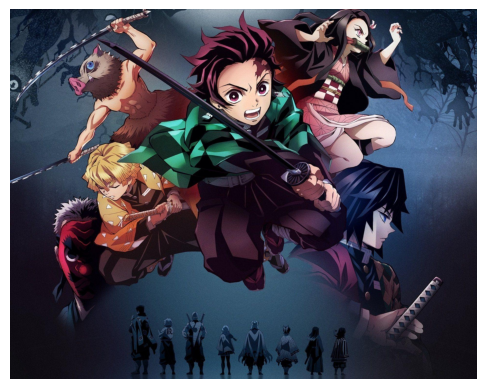

In [2098]:
img = cv2.imread(test_images[-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

In [2099]:
kernel = [[0.4, 0.6, 0.4], [0.6, 0.8, 0.6], [0.4, 0.6, 0.4]]
# kernel = [[1, 0, -1], [1, 0, -1], [1, 0, -1]]

## Convolution

In [2100]:
def add_padding(img, padding):
    try:
        height, width, channels = img.shape
    except:
        try:
            height, width = img.shape # incase greyscale
        except:
            raise ValueError('Image shape is not valid')
    # height, width, channels = img.shap
        
    # if type(pad_size) == tuple:
    #     pad_height, pad_width = pad_size
    # elif type(pad_size) == int:
    #     pad_height, pad_width = pad_size, pad_size
    # else:
    #     pad_height, pad_width = 0, 0
    pad_height, pad_width = padding

    res_height, res_width = height + 2 * pad_height, width + 2 * pad_width

    res = [[[0 for _ in range(channels)] for _ in range(res_width)] for _ in range(res_height)]
    # print(res[pad_height:pad_height+height, pad_width:pad_width+width, :])# = img[:, :, :]
    # res[pad_height:pad_height+height][pad_width:pad_width+width] = img[:][:][:]
    for i in range(height):
        for j in range(width):
            res[i+pad_height][j+pad_width] = img[i][j]

    return res

In [2101]:
def init(img, kernel, padding, stride):
    if type(padding) == tuple:
        pad_height, pad_width = padding
    elif type(padding) == int:
        pad_height, pad_width = padding, padding
    else:
        pad_height, pad_width = 0, 0

    if type(stride) == tuple:
        stride_height, stride_width = stride
    elif type(stride) == int:
        stride_height, stride_width = stride, stride
    else:
        stride_height, stride_width = 1, 1

    res_height = (img.shape[0] - len(kernel) + 2 * pad_height) // stride_height + 1
    res_width = (img.shape[1] - len(kernel[0]) + 2 * pad_width) // stride_width + 1

    img = add_padding(img, (pad_height, pad_width))

    return img, res_height, res_width, stride_height, stride_width

In [2102]:
def convolve(img, kernel, padding=0, stride=1):
    img, res_height, res_width, stride_height, stride_width = init(img, kernel, padding, stride) # gives back the padded image
    res = [[[0 for k in range(len(img[0][0]))] for j in range(res_width)] for i in range(res_height)]
    
    kernel_height = len(kernel)
    kernel_width = len(kernel[0])

    kernel = np.array(kernel) 
    sum_kernel = np.sum(kernel)
    sum_kernel = sum_kernel if sum_kernel > 0 else 1
    res = np.array(res)
    img = np.array(img)

    for k in range(img.shape[-1]):
        for i in range(0, res_height):
            for j in range(0, res_width):
                id_x = i * stride_height
                id_y = j * stride_width
                patch = img[id_x:id_x+kernel_height, id_y:id_y+kernel_width, k]
                # print(patch.shape, kernel.shape, (patch * kernel).shape)
                res[i][j][k] = np.sum(patch * kernel) / sum_kernel
    
    return res

## Matrix Toeplitz

In [2103]:
def toeplitz(img, kernel, padding=0, stride=1):
    img, res_height, res_width, _, _ = init(img, kernel, padding, stride) # gives back the padded image
    # new_img = img.copy()
    new_img = np.array(img)
    # plt.imshow(img)
    # plt.axis('off')
    # plt.show()
    m, n, c = new_img.shape
    kh, kw = len(kernel), len(kernel[0])
    toep = np.zeros((res_height*res_width, m*n))
    kernel = np.array(kernel).flatten()
    sum_kernel = np.sum(kernel)

    # res = np.zeros((res_height, res_width, c))

    # idx = np.zeros((kh, kw))
    # for i in range(kh):
    #     for j in range(kw):
    #         idx[i][j] = i * n + j
    # idx = idx.flatten().astype(int)
    
    
    # c = 1
    # for i in range(res_height*res_width):
    #     # if i + kw < res_width:
    #     toep[i][idx] = kernel
    #     print("idx: ", idx)
    #     # print("kernel: ", kernel)
    #     print("i+kw", c*n-i)
    #     if c*n > i + kw:
    #         idx = idx + 1
    #     else:
    #         idx = idx + kw
            
    #     if i % n == 0:
    #             c += 1
    # i = 0
    # while i < res_height*res_width:
    #     toep[i][idx] = kernel
    #     print("idx: ", idx)
        
    #     if c*n > i + kw:
    #         idx += 1
    #     else:
    #         idx += kw
    #         c += 1

    temp = np.arange(0, m*n).reshape(m, n)
    for i in range(res_height*res_width):
        idx = temp[i//res_width: i//res_width + kh, i%res_width: i%res_width + kw].flatten()
        # print(idx)
        toep[i][idx] = kernel
        
    # print("tope", toep.shape)
    for k in range(c):
        img_c = new_img[:, :, k].flatten().astype(int)
        # plt.imshow(img_c.reshape(32, 32))
        # plt.show()
        toep_c = (np.dot(toep, img_c) / sum_kernel).astype(int)
        # print("tope_c", toep_c.shape)
        toep_c = toep_c.reshape(res_height, res_width)
        res = np.dstack((res, toep_c)) if k > 0 else toep_c
    # res = np.dot(toep, img.flatten()) / sum_kernel

    # print(toep[0][:16])
        
    return res, toep, kernel, new_img

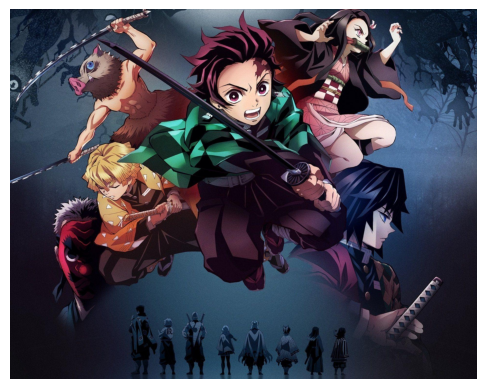

In [2104]:
img = cv2.imread("./data/test4.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

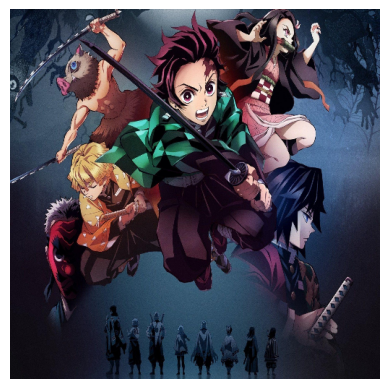

In [2105]:
img512 = cv2.resize(img, (512, 512))
plt.imshow(img512)
plt.axis('off')
plt.show()

In [2106]:
img256 = cv2.resize(img, (256, 256))
img128 = cv2.resize(img, (128, 128))
img64 = cv2.resize(img, (64, 64))
img32 = cv2.resize(img, (32, 32))

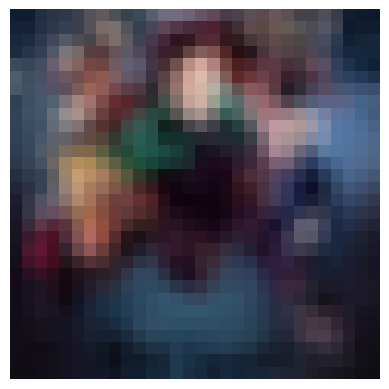

In [2107]:
conv = convolve(img32, kernel, padding=0, stride=1)
plt.imshow(conv)
plt.axis('off')
plt.show()

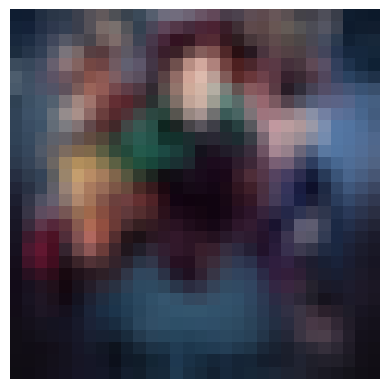

In [2108]:
toep, tope, _, _ = toeplitz(img32, kernel, padding=0, stride=1)
plt.imshow(toep)
plt.axis('off')
plt.show()

## TimeIt

In [2109]:
test_imgs = [img128, img64, img32] # memory constraint with toeplitz for images with size 256x256 and 512x512

In [2110]:
# convolution
conv_times = {}

for img in test_imgs:
    start = time.time()

    for _ in range(5):
        conv = convolve(img, kernel, padding=0, stride=1)
    
    end = time.time()
    conv_times[img.shape[0]] = (end - start) / 5

In [2111]:
# toeplitz
toep_times = {}

for img in test_imgs:
    start = time.time()

    for _ in range(5):
        toep = toeplitz(img, kernel, padding=0, stride=1)

    end = time.time()
    toep_times[img.shape[0]] = (end - start) / 5

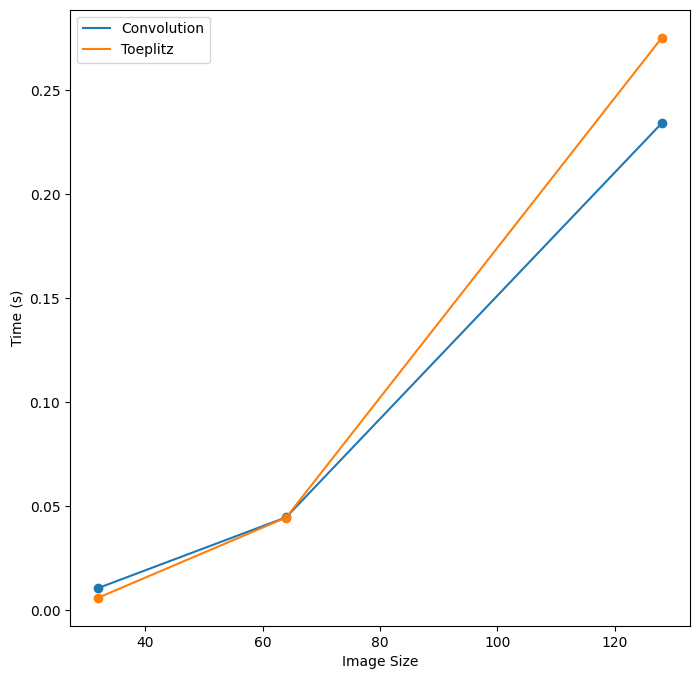

In [2112]:
plt.figure(figsize=(8, 8))
plt.plot(list(conv_times.keys()), list(conv_times.values()), label='Convolution')
plt.scatter(list(conv_times.keys()), list(conv_times.values()))
plt.plot(list(toep_times.keys()), list(toep_times.values()), label='Toeplitz')
plt.scatter(list(toep_times.keys()), list(toep_times.values()))
plt.xlabel('Image Size')
plt.ylabel('Time (s)')
plt.legend()
plt.show()